In [1]:
import time
begin=time.time()
import torch 
import torch.nn as nn
import imageio
from imageio import imread
import matplotlib.pyplot as plt
from IPython import display
# display.set_matplotlib_formats('svg')
import numpy as np

torch.Size([407, 407, 3])


/tmp/ipykernel_24259/2318689924.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imageio.imread('./iithlogo.jpeg')


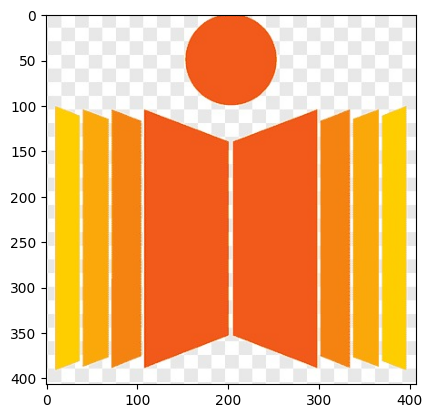

In [2]:
logo = imageio.imread('./iithlogo.jpeg')
logo = torch.from_numpy(logo)
print(logo.size())
plt.imshow(logo)

#https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FIIT_Hyderabad&psig=AOvVaw2H7Q7eOMsow3Xx_A3qZPaD&ust=1677559778477000&source=images&cd=vfe&ved=0CA8QjRxqFwoTCLjD8abztP0CFQAAAAAdAAAAABAE

In [3]:
#preparing a kernel
#gives a random (between -5 and 5) kernel of given dimensions
def prepare_kernel(size,channels):
    Tensor = (torch.rand(size,size,channels)-0.5)*10
    return Tensor

In [4]:
#plots the 3 channeled image 
def plot_image_channels(img,title):
    fig,ax =plt.subplots(1,3,figsize=(8,6))
    fig.suptitle(title,fontsize=12)
    ax[0].imshow(img[:,:,0])
    ax[0].set_title('channel 1')
    
    ax[1].imshow(img[:,:,1])
    ax[1].set_title('channel 2')
    
    ax[2].imshow(img[:,:,2])
    ax[2].set_title('channel 3')

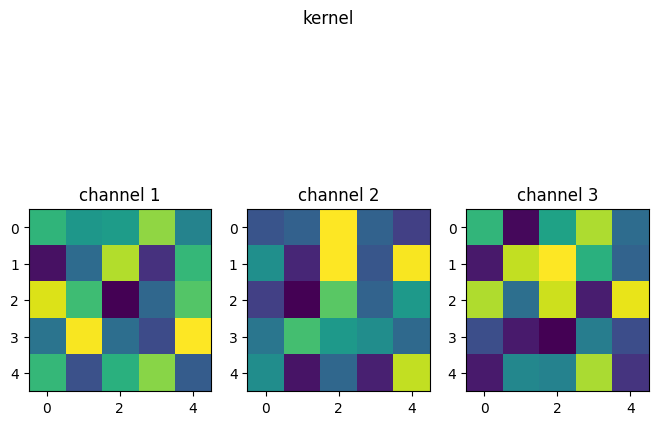

In [5]:
kernel = prepare_kernel(5,3)
plot_image_channels(kernel,'kernel')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


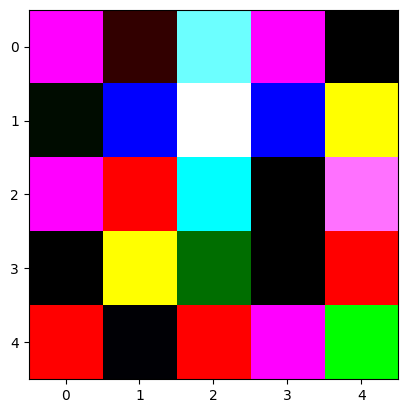

In [6]:
plt.imshow(kernel)

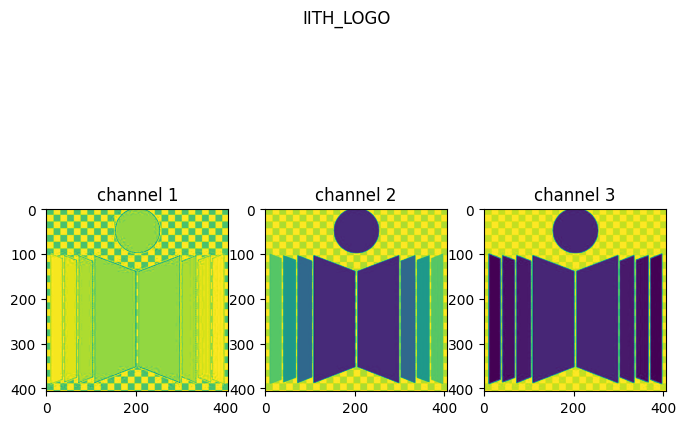

In [7]:
plot_image_channels(logo,'IITH_LOGO')

In [8]:
Sigmoid = lambda Z : 1/(1+torch.exp(-Z))
ReLU = lambda Z : torch.maximum(Z,torch.zeros_like(Z))
Tanh = lambda Z : (torch.exp(Z) - torch.exp(-Z))/(torch.exp(Z) + torch.exp(-Z))
PReLU = lambda Z : torch.maximum(torch.zeros_like(Z),Z) + (0.25)*torch.minimum(torch.zeros_like(Z),Z)

In [9]:
#accepts the kernel as Parameter for the function
def convolution(image,kernel,stride,padding,activation):
    pad = torch.nn.ZeroPad2d(padding) # pads in the order (top bottom left right)
    newimage = image.permute(2,0,1) #separating the channels
    newimage = pad(newimage)
    halfkernel = (kernel.size(0))//2
    width = (newimage.size(1)-stride[0]+2*padding[1])//stride[0] + 1
    height = (newimage.size(2)-stride[1]+2*padding[2])//stride[1] + 1
    convoutput = torch.zeros(1,width,height)
    
    #convolution----------------------------------------------------------------------------------
    for i in range(newimage.size(0)):
        for row in range(halfkernel,newimage.size(1)-halfkernel,stride[0]):
            for col in range(halfkernel,newimage.size(2)-halfkernel,stride[1]):
                img = newimage[i,row-halfkernel:row+halfkernel+1,:]
                img = img[:,col-halfkernel:col+halfkernel+1]
                convolve =  torch.sum(torch.mul(img,kernel[:,:,i]))
                a = (row-halfkernel)//stride[0] #corresponding row in convoutput
                b = (col-halfkernel)//stride[1] #corresponding col in convoutput
                convoutput[0][a][b] = convoutput[0][a][b] + convolve #adding convolution of all channels
    #----------------------------------------------------------------------------------------------
    
    
#activation(convoutput) - tensor after passing the convoutput to the required the activation function 
#.permute is used to change the seprated channels into the image
    return activation(convoutput).permute(1,2,0)
            

Text(0.5, 1.0, 'channel 1')

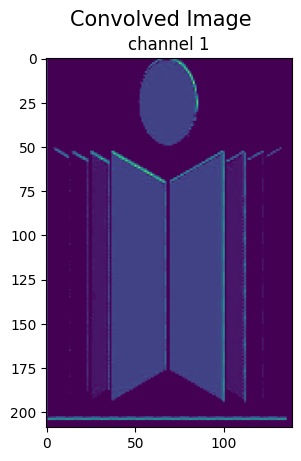

In [10]:
resimage = convolution(logo,kernel,(2,3),(3,3,3,3),ReLU) #resimage is the output of the image after convolution
plt.suptitle('Convolved Image',fontsize = 15)
plt.imshow(resimage)
plt.title('channel 1')

In [11]:
min_pooling = lambda Z : torch.min(Z)
max_pooling = lambda Z : torch.max(Z)
avg_pooling = lambda Z : torch.sum(Z)/(Z.size(0))

In [12]:
def pool_function(input_activation,function,stride) :
    width = (input_activation.size(0)-stride)//stride + 1
    height = (input_activation.size(1)-stride)//stride + 1
    newimage = torch.zeros(width,height)
    halfkernel = stride//2
    
    #pooling-----------------------------------------------------------------------
    for row in range(halfkernel,input_activation.size(0)-halfkernel,stride):
        for col in range(halfkernel,input_activation.size(1)-halfkernel,stride):
            img = input_activation[row-halfkernel:row+halfkernel+1,:]
            img = img[:,col-halfkernel:col+halfkernel+1]
            a = (row-halfkernel)//stride
            b = (col-halfkernel)//stride
            newimage[a,b] = function(img)
    #-------------------------------------------------------------------------------
    
    return newimage

In [13]:
pooled_image = pool_function(resimage,max_pooling,3) #pooled_image is the output of the convolved image after pooling
pooled_image.size()#we can see that the size matches of that required after passing through pooling function

torch.Size([69, 46])

Text(0.5, 1.0, 'channel 1')

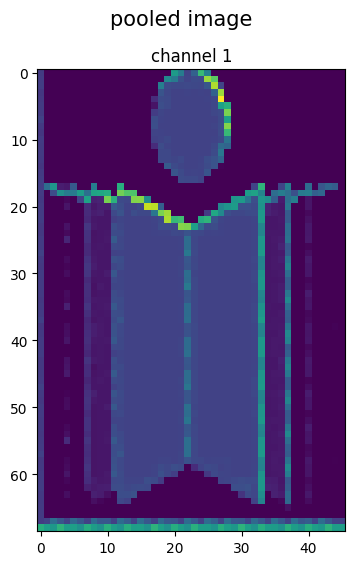

In [14]:
fig,ax =plt.subplots(1,1,figsize=(8,6))
fig.suptitle('pooled image',fontsize=15)
ax.imshow(pooled_image)
ax.set_title('channel 1')

In [15]:
m = nn.MaxPool2d(3, stride=3)
resimage = resimage.to(dtype = torch.float32)
view_tensor = resimage.view(1,1,resimage.size(0),resimage.size(1))
output = m(view_tensor)
output[0,0,:,:].size()

torch.Size([69, 46])

Text(0.5, 1.0, 'channel 1')

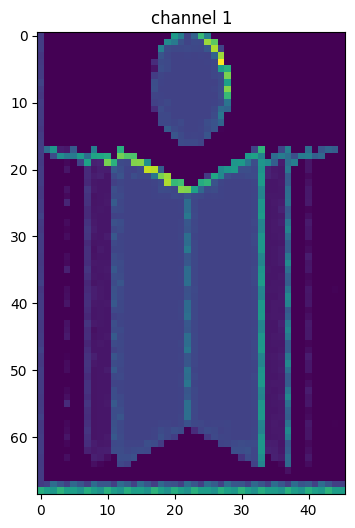

In [16]:
fig,ax =plt.subplots(1,1,figsize=(8,6))
# fig.suptitle(title,fontsize=15)
ax.imshow(output[0,0,:,:])
ax.set_title('channel 1')
    